# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
data_dir = 'dataset'

# Define transforms
train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                       ])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10(data_dir + '/train', download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10(data_dir + '/test', download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(train_data, batch_size=64)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

horse


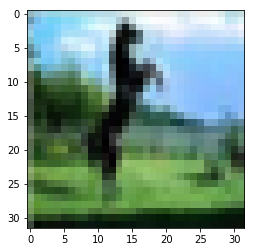

plane


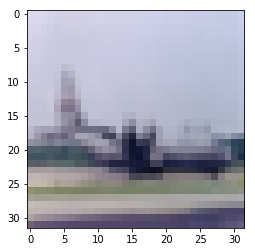

bird


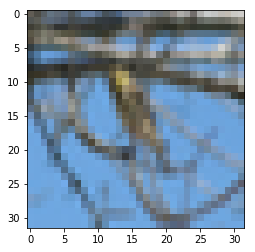

frog


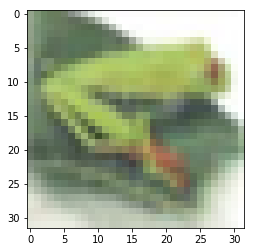

cat


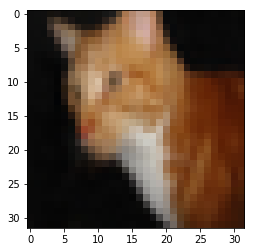

torch.Size([64, 3, 32, 32])

In [4]:
# Explore data
show5(trainloader)
dataiter = iter(trainloader)
batch = next(dataiter)
batch[0].shape

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.conv2 = nn.Conv2d(12, 20, 5)
        
        self.fc1 = nn.Linear(500, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10)
        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003) #Rethinking recurring neural [..] arbeitet mit e^-4 bis -6, also 0.0025

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

epochs = 30
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 1.633..  Test Loss: 1.413..  Test Accuracy: 0.484
Epoch: 2/30..  Training Loss: 1.358..  Test Loss: 1.365..  Test Accuracy: 0.515
Epoch: 3/30..  Training Loss: 1.250..  Test Loss: 1.202..  Test Accuracy: 0.574
Epoch: 4/30..  Training Loss: 1.170..  Test Loss: 1.242..  Test Accuracy: 0.553
Epoch: 5/30..  Training Loss: 1.122..  Test Loss: 1.110..  Test Accuracy: 0.605
Epoch: 6/30..  Training Loss: 1.075..  Test Loss: 1.033..  Test Accuracy: 0.633
Epoch: 7/30..  Training Loss: 1.041..  Test Loss: 1.019..  Test Accuracy: 0.645
Epoch: 8/30..  Training Loss: 1.013..  Test Loss: 0.944..  Test Accuracy: 0.670
Epoch: 9/30..  Training Loss: 0.977..  Test Loss: 0.938..  Test Accuracy: 0.670
Epoch: 10/30..  Training Loss: 0.964..  Test Loss: 1.002..  Test Accuracy: 0.646
Epoch: 11/30..  Training Loss: 0.948..  Test Loss: 0.901..  Test Accuracy: 0.682
Epoch: 12/30..  Training Loss: 0.928..  Test Loss: 0.875..  Test Accuracy: 0.691
Epoch: 13/30..  Training Loss: 0.904.

Plot the training loss (and validation loss/accuracy, if recorded).

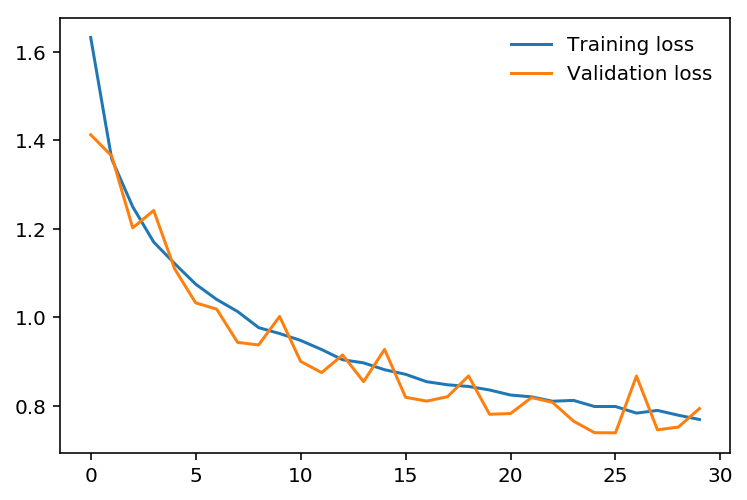

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [16]:
test_loss = 0
accuracy = 0
        
with torch.no_grad():
    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

        print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
        "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Loss: 0.001..  Test Accuracy: 0.001
Test Loss: 0.002..  Test Accuracy: 0.002
Test Loss: 0.003..  Test Accuracy: 0.003
Test Loss: 0.004..  Test Accuracy: 0.004
Test Loss: 0.004..  Test Accuracy: 0.005
Test Loss: 0.005..  Test Accuracy: 0.006
Test Loss: 0.006..  Test Accuracy: 0.007
Test Loss: 0.008..  Test Accuracy: 0.008
Test Loss: 0.009..  Test Accuracy: 0.009
Test Loss: 0.010..  Test Accuracy: 0.009
Test Loss: 0.011..  Test Accuracy: 0.010
Test Loss: 0.012..  Test Accuracy: 0.011
Test Loss: 0.013..  Test Accuracy: 0.012
Test Loss: 0.014..  Test Accuracy: 0.013
Test Loss: 0.015..  Test Accuracy: 0.014
Test Loss: 0.017..  Test Accuracy: 0.015
Test Loss: 0.018..  Test Accuracy: 0.015
Test Loss: 0.018..  Test Accuracy: 0.016
Test Loss: 0.019..  Test Accuracy: 0.017
Test Loss: 0.020..  Test Accuracy: 0.018
Test Loss: 0.021..  Test Accuracy: 0.019
Test Loss: 0.022..  Test Accuracy: 0.020
Test Loss: 0.023..  Test Accuracy: 0.021
Test Loss: 0.025..  Test Accuracy: 0.022
Test Loss: 0.026

## Saving your model
Using `torch.save`, save your model for future loading.

In [17]:
torch.save(model.state_dict(), "model")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

**How does your model compare to Detectocorp's model?**

The model performs slightly better with an accuracy of 71,9% compared to Detecorp's 70%.


**How does it compare to the far more advanced solutions in the literature?**

As it's only performing slightly higher than 70% it's also far from the accuracys of the solutions in the literature.

On the other hand, training the model only needs a couple of minutes of time and not a whole week as in some of the solutions in the literature. It's also far less complex as them.


**What did you do to get the accuracy you achieved?**

My first step to achieve this accuracy was to mess up royally.
I started this assignment by rebuilding the previous exercises, just to have a working basis from which I could improve the model. For some reason I was convinced that the orignal size of the pictures was 255 x 255 pixels, so I resized them to 224, just like in exercise eight. That made the input nodes for the first layer gigantic (somewhere around 150k), as I started out with five linear networks. I got my first doubts, but couldn't point my finger on the error, so I soldiered on, to at least get the first data for the accuracy.


The training for one epoch took a very long time, even with the GPU enabled and yielded 10% (which is perfect guessing at ten outputs), only to rise to 10,1% in the following epochs.


I was pretty sure it had something to do with the number of the input nodes and there had to be a way to lower them with linear networks. There wasn't (or at least I couldn't find one). But the comment to that part of the assigment mentioned convolutional networks, so I looked for those and found Conv2D. It could also be found in the papers and their github repos and looking at it's documentation and some web pages explained to me, that it's input parameters were independend from the image size. However, after building two layers, I didn't know how to use the output. Flattening it and using it as an input for the another linear network seemed to be the answer and luckily the size went down a fair bit (by about a third), but I still feeled that I would need at least three linear layers to get the number of nodes down to 10 in a reasonable way.


The result was a bit faster, but as inaccurate as before.
Looking for solutions I deleted all but the basic transform steps, looked at the data and realized my mistake.
After adjusting the linear layers I started the training again and was feeling lucky to see the model exceed 70%.... and also **pretty** angry at myself.


I tried to improve the models performance by putting some of the transform parts back into the code, but it made things worse a bit, so it didn't make sense to keep it. Dropout didn't make a lot of sense either, as the model didn't seem to overfit. I tried it anyway. 

It didn't get worse. 

It also didn't get better.

It got dropped again.


This whole process took me **way** longer than I would like to admit, but at least it gave me a solid model... solely by accident.



**Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?**

An accuracy of little more than 71,9% for a detection algorithm for stationary objects at the site of a road seems very low and risky. Also, it's always better to improve a model, if it's possible.

Possible next steps could be some new combinations of layers, or additional layers. Putting in new transform steps could also be a next step, though the ones tried have performed rather badly.

Also, increasing the number of trainig data could possibly help.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).